# Cycle GAN
<p>
    Блокнот создан с целью изучения циклических генеративно-состязательных моделей и попытки воспроизвести результаты статьи:<br>
    <a href='https://arxiv.org/pdf/1703.10593.pdf'>https://arxiv.org/pdf/1703.10593.pdf</a>
</p>
<p>
    Cycle GAN позволяет применить к изображению из множества X некоторую особенность изображений из множества Y. Например, сделать картины Моне реалистичными фотографиями или выполнить их в стиле Ван Гога. Можно преобразовать летний пейзаж в зимний или сделать из лошади зебру.
</p>
<p>
    В отличии от других подходов к преобразованию изображений, в данной задаче довольно сложно найти парные данные в достаточном для обучения количестве. Чтобы решить эту проблему, авторы статьи предлагают обучить два преобразования Y = F(X) и X = G(Y) на двух независимых наборах данных X и Y так, что x ~ G(F(x)) и y ~ F(G(y)). Несмотря на то, что в обучении нет явных пар, предполагается, что изображения всё же имеют схожую тематику. Отсутствие дополнительных условий и ограничений делает такое решение универсальным.
</p>

### Лошади и зебры
<p>
    В качестве примера, попробуем преобразовать лошадь в зебру на основе данных horse2zebra.zip:<br>
    <a href="https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/">https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/</a>
</p>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as tt

from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#!powershell -NoP -NonI -Command "Expand-Archive '.\horse2zebra.zip' '.\'"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from pathlib import Path
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, path, device):
        super().__init__()
        
        prepair = tt.Compose([
            tt.Resize(150),
            tt.CenterCrop(150)])
        
        self._images = []
        for file in Path(path).rglob('*.jpg'):
            image = Image.open(file)
            image.load()
            self._images.append(prepair(image))
        
        self._transform = tt.Compose([
            tt.RandomCrop(128),
            tt.RandomHorizontalFlip(p=0.5),
            tt.ToTensor(),
            tt.Normalize(0.5, 0.5)])
        
        self._device = device
        self._loader = DataLoader(self, batch_size=1, shuffle=True)
    
    def loader(self):
        return self._loader
    
    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, index):
        x = self._images[index]
        x = self._transform(x)
        
        # 8-bit
        if (x.shape[0] == 1):
            x = x.repeat(3, 1, 1)
        
        return x.to(self._device)

In [5]:
horse_loader = ImageDataset("./horse2zebra/trainA/", device).loader()
zebra_loader = ImageDataset("./horse2zebra/trainB/", device).loader()

Посмотрим на изображения лошадей и зебр:

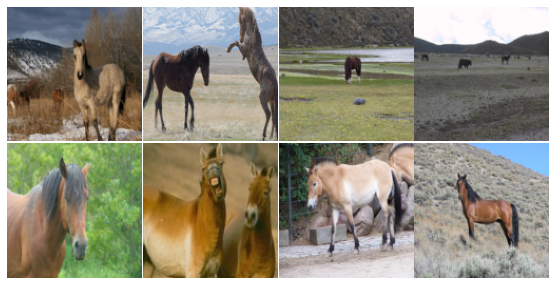

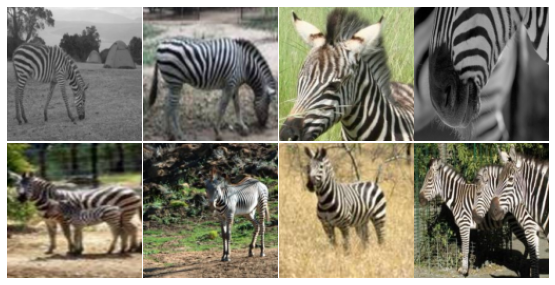

In [6]:
def show_images(batch):
    batch = batch.to('cpu')
    plt.figure(figsize=(9.7, 5))
    for i in range(2):
        for j in range(4):    
            plt.subplot(2, 4, 4 * i + j + 1)          
            plt.axis("off")
            plt.subplots_adjust(wspace=0.01, hspace=0.01)
            plt.imshow((batch[4 * i + j] * 0.5 + 0.5).permute(1, 2, 0))

def save_images(name, horse_batch, zebra_batch):
    save_image(make_grid(torch.cat((horse_batch, zebra_batch)) * 0.5 + 0.5, nrow=4), f'./test/{name}.jpg')


def get_8_images(loader):
    xs = []
    for x in loader:
        xs.append(x)
        if (x.shape[0] * len(xs) >= 8):
            break
    return torch.cat(xs)[:8]

# fixed images
path = Path('./test')
if not path.exists():
    horse_batch = get_8_images(horse_loader)
    zebra_batch = get_8_images(zebra_loader)
    
    images = {
        'horse': horse_batch.to('cpu'),
        'zebra': zebra_batch.to('cpu')
    }
    
    path.mkdir()
    torch.save(images, f'test/images.pt')
else:
    images = torch.load(f'test/images.pt')
    
    horse_batch = images['horse'].to(device)
    zebra_batch = images['zebra'].to(device)
    
show_images(horse_batch)
show_images(zebra_batch)

save_images('source', horse_batch, zebra_batch)

In [7]:
# Из-за ограничения по памяти (~1 ГБ) все модели содержат небольшое количество параметров (G ~10 млн; D ~5 млн).
# Каждый параметр занимает:
# - 4 байта под значение
# - 4 байта под градиент (можно удалять, используя zero_grad(set_to_none=True))
# - 8 байт в оптимизаторе Adam
# Часть памяти также нужна для промежуточных вычислений; остального хватило для batch_size=8

# print(torch.cuda.memory_summary())
# sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
lr = 0.0002
betas = (0.5, 0.999)

def conv_block(
    isize, osize, kernel, stride, padding, 
    activation=None, 
    normalize=True, 
    dropout=False, 
    transpose=False, 
    reflect=False):
    
    modules = []
    
    if (reflect):
        modules.append(nn.ReflectionPad2d(padding))
        padding = 0
    
    if (transpose):
        modules.append(nn.ConvTranspose2d(isize, osize, kernel_size=kernel, stride=stride, padding=padding, bias=normalize))
    else:
        modules.append(nn.Conv2d(isize, osize, kernel_size=kernel, stride=stride, padding=padding, bias=normalize))
    
    if (normalize):
        modules.append(nn.InstanceNorm2d(osize, affine=False, track_running_stats=False))
    
    if (dropout):
        modules.append(nn.Dropout(p=0.5, inplace=True))

    if (activation == 'leaky'):
        modules.append(nn.LeakyReLU(0.2, inplace=True))        
    elif (activation == 'relu'):
        modules.append(nn.ReLU(inplace=True))    
    elif (activation == 'tanh'):
        modules.append(nn.Tanh())
    
    return nn.Sequential(*modules)

def conv_block_4_2(isize, osize, **kwargs):
    return conv_block(isize, osize, 4, 2, 1, **kwargs)

def conv_block_3_1(isize, osize, **kwargs):
    return conv_block(isize, osize, 3, 1, 1, **kwargs)

def conv_transpose_block_4_2(isize, osize, **kwargs):
    return conv_block(isize, osize, 4, 2, 1, transpose=True, **kwargs)

def conv_block_7_1(isize, osize, **kwargs):
    return conv_block(isize, osize, 7, 1, 3, **kwargs)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

### Генератор
Построим генератор на основе U-net модели:<br>
<a href="https://www.tensorflow.org/tutorials/generative/pix2pix">https://www.tensorflow.org/tutorials/generative/pix2pix</a>

In [9]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._down = nn.ModuleList([
            conv_block_4_2(3, 64, activation='leaky', normalize=False), # 128 -> 64
            conv_block_4_2(64, 128, activation='leaky'),                # 64 -> 32
            conv_block_4_2(128, 256, activation='leaky'),               # 32 -> 16
            conv_block_4_2(256, 256, activation='leaky'),               # 16 -> 8
            conv_block_4_2(256, 256, activation='leaky')])              # 8 -> 4
        
        self._up = nn.ModuleList([
            conv_transpose_block_4_2(256, 256, activation='relu'),      # 4 -> 8
            conv_transpose_block_4_2(512, 256, activation='relu'),      # 8 -> 16
            conv_transpose_block_4_2(512, 128, activation='relu'),      # 16 -> 32
            conv_transpose_block_4_2(256, 64, activation='relu')])      # 32 -> 64
        
        self._last = conv_transpose_block_4_2(128, 3, activation="tanh", normalize=False)
        
        self.apply(init_weights)
        self._optimizer = torch.optim.Adam(self.parameters(), lr, betas)
    
    def optimizer(self):
        return self._optimizer
    
    def forward(self, x):
        skips = []
        for downsample in self._down:
            x = downsample(x)
            skips.append(x)
        
        for upsample, skip in zip(self._up, skips[-2::-1]):
            x = upsample(x)
            x = torch.cat((x, skip), 1)
        
        return self._last(x)

И генератор на основе ResNet:

In [10]:
# https://arxiv.org/pdf/1512.03385.pdf
class ResNetBlock(nn.Module):
    def __init__(self, dim, dropout=False):
        super().__init__()
        
        self._f = nn.Sequential(
            conv_block_3_1(dim, dim, activation='relu', dropout=dropout, reflect=True),
            conv_block_3_1(dim, dim, reflect=True))
    
    def forward(self, x):
        return x.add(self._f(x))

# https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf
class ResNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._f = nn.Sequential(
            conv_block_7_1(3, 64, activation='relu', reflect=True),
            conv_block_4_2(64, 128, activation='relu'),
            conv_block_4_2(128, 256, activation='relu'),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            conv_transpose_block_4_2(256, 128, activation='relu'),
            conv_transpose_block_4_2(128, 64, activation='relu'),
            conv_block_7_1(64, 3, activation='tanh', normalize=False, reflect=True))
    
        self.apply(init_weights)
        self._optimizer = torch.optim.Adam(self.parameters(), lr, betas)
    
    def optimizer(self):
        return self._optimizer
    
    def forward(self, x):
        return self._f(x)

А теперь объединим два подхода:

In [11]:
class MixGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._first = conv_block_7_1(3, 64, activation='relu', reflect=True)
        
        self._down = nn.ModuleList([
            conv_block_4_2(64, 128, activation='leaky', normalize=False), # 128 -> 64
            conv_block_4_2(128, 256, activation='leaky')])                # 64 -> 32
        
        self._neck = nn.Sequential(
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256),
            ResNetBlock(256))
        
        self._up = nn.ModuleList([
            conv_transpose_block_4_2(512, 128, activation='relu'),        # 16 -> 32
            conv_transpose_block_4_2(256, 64, activation='relu')])        # 32 -> 64
        
        self._last = conv_block_7_1(64, 3, activation='tanh', normalize=False, reflect=True)
        
        self._optimizer = torch.optim.Adam(self.parameters(), lr, betas)
    
    def optimizer(self):
        return self._optimizer
    
    def forward(self, x):
        x = self._first(x)
        
        skips = []
        for downsample in self._down:
            x = downsample(x)
            skips.append(x)
        
        x = self._neck(x)
        
        for upsample, skip in zip(self._up, skips[::-1]):
            x = torch.cat((x, skip), 1)
            x = upsample(x)            
        
        return self._last(x)

In [12]:
# generator_x2y = UNetGenerator().to(device)
# generator_y2x = UNetGenerator().to(device)

# generator_x2y = ResNetGenerator().to(device)
# generator_y2x = ResNetGenerator().to(device)

generator_x2y = MixGenerator().to(device)
generator_y2x = MixGenerator().to(device)

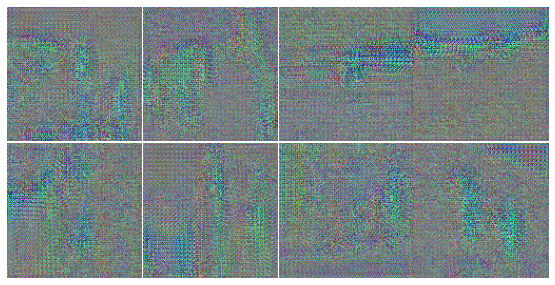

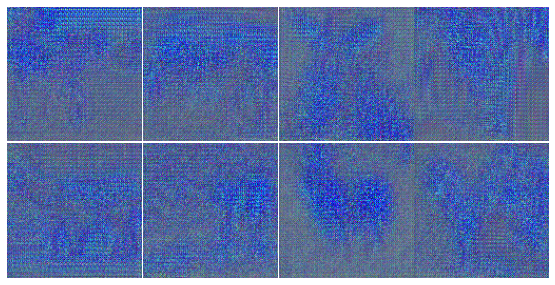

In [13]:
def generate_batch(generator, batch):
    with torch.no_grad():
        generator.eval()
        return generator(batch)

def generate_horses():
    return generate_batch(generator_y2x, zebra_batch)

def generate_zebras():
    return generate_batch(generator_x2y, horse_batch)

def generate():
    return (generate_zebras(), generate_horses())
    
generated = generate()
save_images(0, *generated)

show_images(generated[0])
show_images(generated[1])

### Дискриминатор
Построим дискриминатор на основе Patch-GAN:

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self._f = nn.Sequential(
            conv_block_4_2(3, 64, activation='leaky', normalize=False), # 128 -> 64
            conv_block_4_2(64, 128, activation='leaky'),                # 64 -> 32
            conv_block_4_2(128, 256, activation='leaky'),               # 32 -> 16
            conv_block_3_1(256, 512, activation='leaky'),
            conv_block_3_1(512, 1, normalize=False),
            nn.Flatten(),
            nn.Sigmoid())
        
        self.apply(init_weights)
        self._optimizer = torch.optim.Adam(self.parameters(), lr, betas)
    
    def optimizer(self):
        return self._optimizer
    
    def forward(self, x):
        return self._f(x)

In [15]:
discriminator_x = Discriminator().to(device)
discriminator_y = Discriminator().to(device)

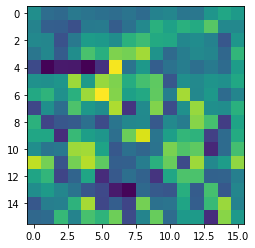

In [16]:
with torch.no_grad():
    discriminator_x.eval()
    p = discriminator_x(horse_batch)
    plt.imshow(p[0].reshape(16, 16).to('cpu'))

### Функции потерь
<p>
    Функции потерь для дискриминатора и генератора не отличаются от реализованной в GAN:
</p>

In [17]:
def discriminator_loss(fake, real):
    criterion = nn.BCELoss()
    
    one = torch.rand(real.shape, device=device) * 0.3 + 0.7
    zero = torch.rand(real.shape, device=device) * 0.3
    
    return 0.5 * (criterion(one, real) + criterion(zero, fake))

In [18]:
def generator_loss(fake):
    criterion = nn.BCELoss()
    return criterion(fake, torch.ones(fake.shape).to(device))

<p>
    Но нам также необходимо добавить функции потерь для циклической согласованности и идентичности преобразований:
</p>

In [19]:
def similarity_loss(fake, real):
    criterion = nn.L1Loss()
    return criterion(fake, real)

### Checkpoint

In [20]:
Path('./models').mkdir(exist_ok=True)

def save(epoch):
    each = 1
    if (epoch % each == 0):
        checkpoint = {
            "g_x2y": generator_x2y.state_dict(),
            "g_x2y_optimizer": generator_x2y.optimizer().state_dict(),
            "g_y2x": generator_y2x.state_dict(),
            "g_y2x_optimizer": generator_y2x.optimizer().state_dict(),
            "d_x": discriminator_x.state_dict(),
            "d_x_optimizer": discriminator_x.optimizer().state_dict(),
            "d_y": discriminator_y.state_dict(),
            "d_y_optimizer": discriminator_y.optimizer().state_dict()
        }    
        torch.save(checkpoint, f'models/{epoch}.pt')
    
        # clean-up
        ancient = epoch - 2 * each
        if (ancient > 0):
            Path(f'./models/{ancient}.pt').unlink()

def load(epoch):
    checkpoint = torch.load(f'models/{epoch}.pt')
    
    generator_x2y.load_state_dict(checkpoint["g_x2y"])
    generator_x2y.optimizer().load_state_dict(checkpoint["g_x2y_optimizer"])
    generator_y2x.load_state_dict(checkpoint["g_y2x"])
    generator_y2x.optimizer().load_state_dict(checkpoint["g_y2x_optimizer"])
    discriminator_x.load_state_dict(checkpoint["d_x"])
    discriminator_x.optimizer().load_state_dict(checkpoint["d_x_optimizer"])
    discriminator_y.load_state_dict(checkpoint["d_y"])
    discriminator_y.optimizer().load_state_dict(checkpoint["d_y_optimizer"])

In [21]:
# load(?)
load(10)

### Цикл обучения
Обучение генератора:
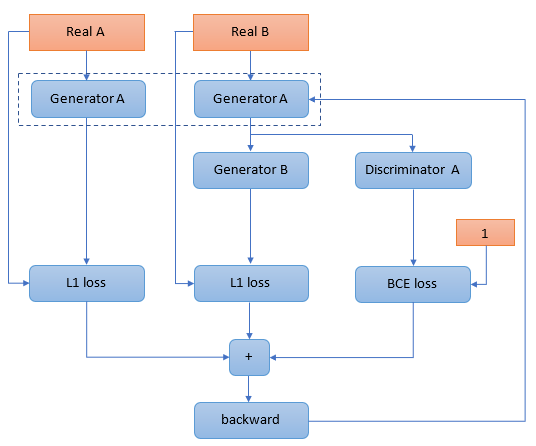
Обучение дискриминатора:
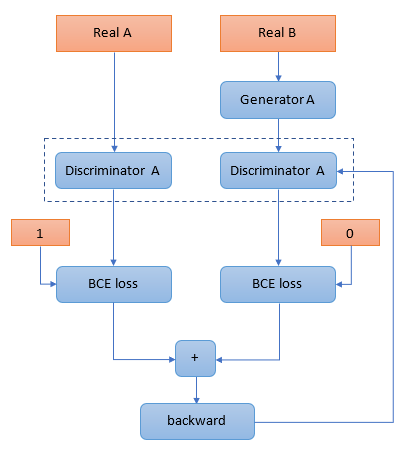

In [22]:
def discriminator_step(discriminator, forward, image, target):
    discriminator.zero_grad()
    
    real = discriminator(target)
    fake = discriminator(forward(image).detach())
    
    loss = discriminator_loss(fake, real)
    loss.backward()
    
    discriminator.optimizer().step()
    
    del real, fake
    torch.cuda.empty_cache()
    
    return loss.item()

def generator_step(forward, backward, discriminator, image, target):
    lm = 10
    
    forward.zero_grad()
    
    same = forward(target)
    identity_loss = similarity_loss(same, target)
    
    fake = forward(image)
    generation_loss = generator_loss(discriminator(fake))
    
    cycle = backward(fake)
    cycle_loss = similarity_loss(cycle, image)
    
    loss = 0.5 * lm * identity_loss + generation_loss + lm * cycle_loss
    loss.backward()
    
    forward.optimizer().step()
    
    del same, fake, cycle
    torch.cuda.empty_cache()
    
    return loss.item()

def step(x, y):
    discriminator_step(discriminator_x, generator_y2x, y, x)
    discriminator_step(discriminator_y, generator_x2y, x, y)
    
    generator_step(generator_x2y, generator_y2x, discriminator_y, x, y)
    generator_step(generator_y2x, generator_x2y, discriminator_x, y, x)
    
def fit(x_loader, y_loader, from_epoch, to_epoch):
    discriminator_x.train()
    discriminator_y.train()
    generator_x2y.train()
    generator_y2x.train()
    
    for epoch in tqdm(range(from_epoch, to_epoch + 1)):
        for x, y in zip(x_loader, y_loader):
            if (x.shape == y.shape):
                step(x, y)
            
            del x, y
            torch.cuda.empty_cache()
        
        save(epoch)
        save_images(epoch, *generate())

In [23]:
#fit(horse_loader, zebra_loader, 1, 10)

In [24]:
fit(horse_loader, zebra_loader, 11, 50)

  0%|          | 0/40 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### Полезные материалы
<br>
<lt>
    <li><a href="https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix">GitHub: CycleGAN and pix2pix in PyTorch</a></li>
    <li><a href="https://arxiv.org/pdf/1703.10593.pdf">Original article: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks</a></li>
    <li><a href="https://www.tensorflow.org/tutorials/generative/cyclegan">TensorFlow CycleGAN tutorial</a></li>
</lt>